In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=647b9aabfd9075a228e4e454178d3cdb3a47434ea38869c34405eaeeed09865d
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Energy_Consumption_Project').getOrCreate()

df1 = spark.read.csv('/content/drive/MyDrive/DATASETS/CSE3120-BDF_Project/household_power_consumption.txt', sep =';',inferSchema=True, header=True)


In [ ]:
#Checking NULL Values

from pyspark.sql.functions import col,sum,isnan,avg
df1.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df1.columns)).show()

+----+----+-------------------+---------------------+-------+----------------+--------------+--------------+--------------+
|Date|Time|Global_active_power|Global_reactive_power|Voltage|Global_intensity|Sub_metering_1|Sub_metering_2|Sub_metering_3|
+----+----+-------------------+---------------------+-------+----------------+--------------+--------------+--------------+
|   0|   0|                  0|                    0|      0|               0|             0|             0|         25979|
+----+----+-------------------+---------------------+-------+----------------+--------------+--------------+--------------+



In [ ]:
# Display the average values

avg_values = df1.agg(*(avg(col(c)).alias(c) for c in df1.columns))
avg_values.show()

+----+--------------------+-------------------+---------------------+-----------------+-----------------+------------------+------------------+----------------+
|Date|                Time|Global_active_power|Global_reactive_power|          Voltage| Global_intensity|    Sub_metering_1|    Sub_metering_2|  Sub_metering_3|
+----+--------------------+-------------------+---------------------+-----------------+-----------------+------------------+------------------+----------------+
|null|1.6897679727448092E9| 1.0916150365007122|  0.12371447630388838|240.8398579745544|4.627759310588417|1.1219233096502186|1.2985199679887571|6.45844735712055|
+----+--------------------+-------------------+---------------------+-----------------+-----------------+------------------+------------------+----------------+



In [ ]:
df1.describe().show()

+-------+--------+-------------------+---------------------+------------------+-----------------+------------------+------------------+-----------------+
|summary|    Date|Global_active_power|Global_reactive_power|           Voltage| Global_intensity|    Sub_metering_1|    Sub_metering_2|   Sub_metering_3|
+-------+--------+-------------------+---------------------+------------------+-----------------+------------------+------------------+-----------------+
|  count| 2075259|            2075259|              2075259|           2075259|          2075259|           2075259|           2075259|          2049280|
|   mean|    null| 1.0916150365007122|  0.12371447630388838| 240.8398579745544|4.627759310588417|1.1219233096502186|1.2985199679887571| 6.45844735712055|
| stddev|    null| 1.0572941610939701|   0.1127219795507155|3.2399866790098937|4.444396259786192|  6.15303108970134| 5.822026473177461|8.437153908665614|
|    min|1/1/2007|              0.076|                0.000|           223.2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DATASETS/CSE3120-BDF_Project/household_power_consumption.txt', sep=';',
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True,
                 low_memory=False, na_values=['nan','?'], index_col='dt')
#df.to_csv('/content/household_power_consumption.csv')

df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [ ]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [ ]:
df = df.fillna(df.mean())

In [ ]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

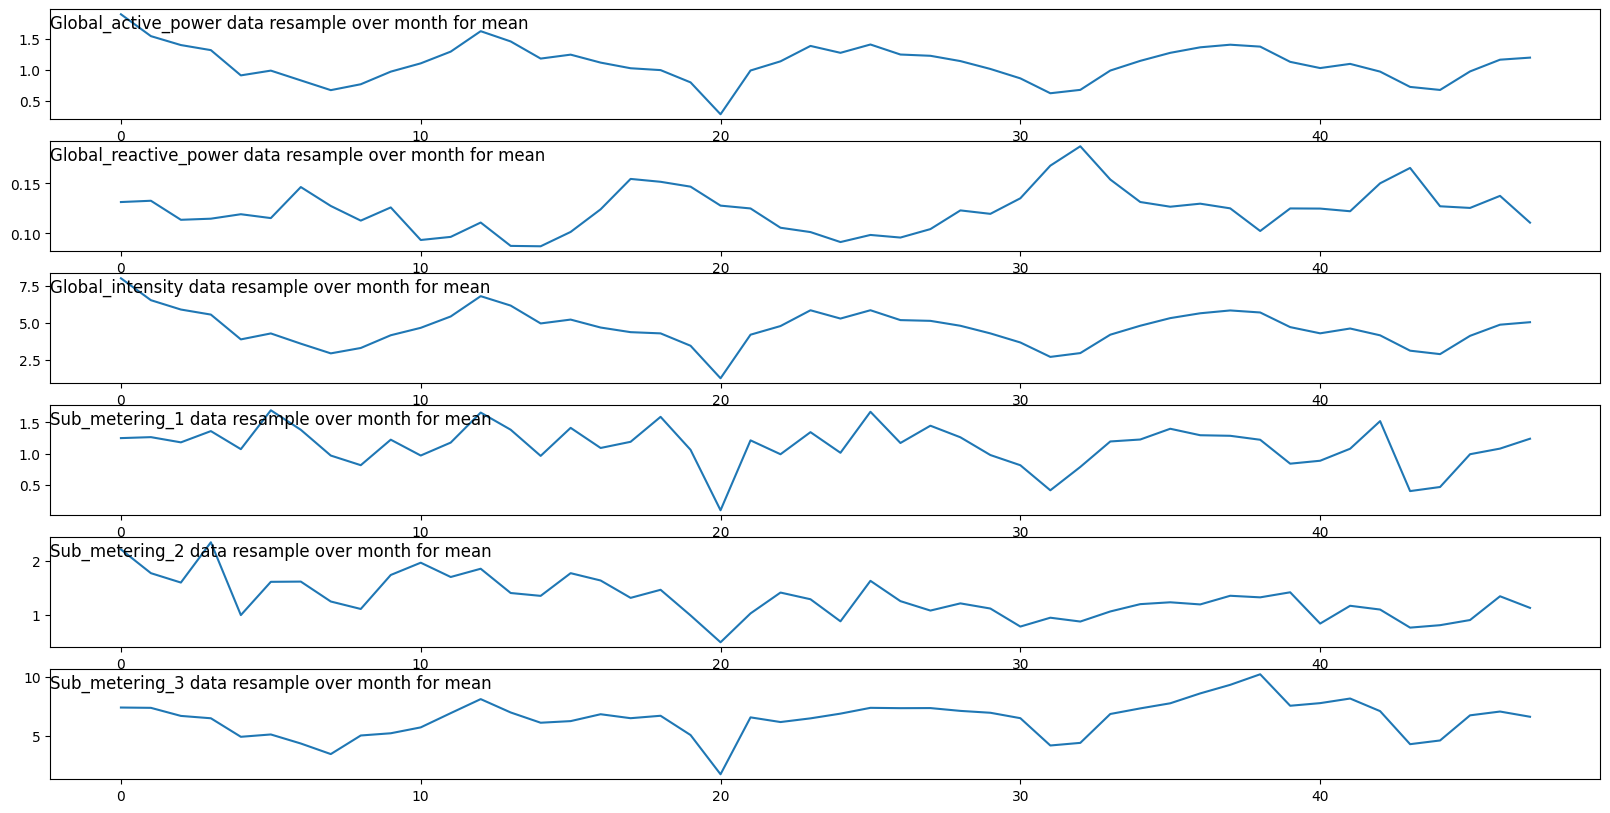

In [ ]:
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('M').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over month for mean', y=0.75, loc='left')
    i += 1
plt.show()

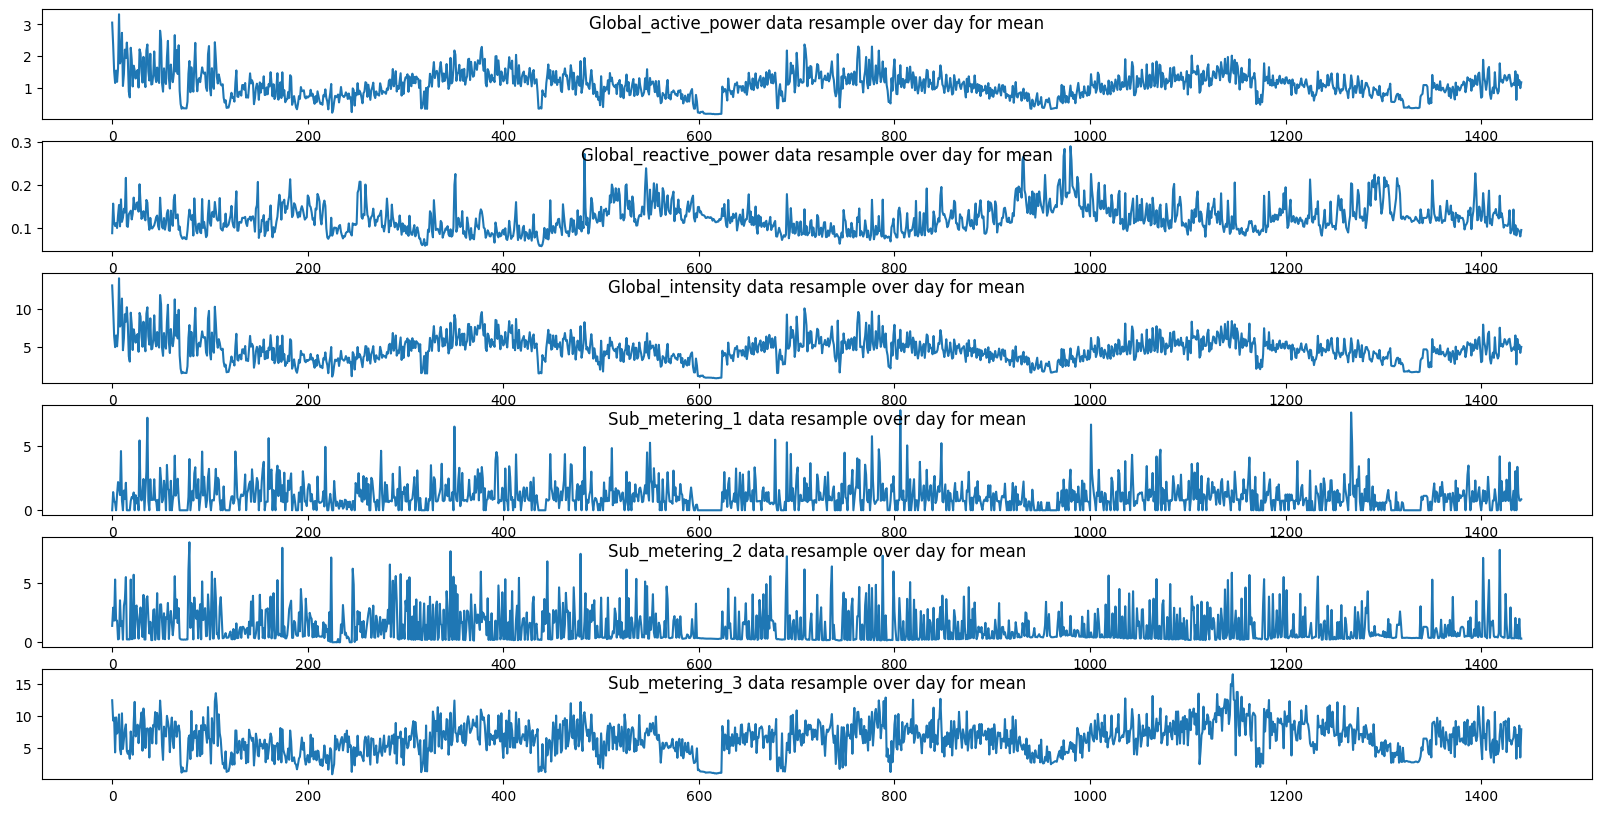

In [ ]:
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('D').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over day for mean', y=0.75, loc='center')
    i += 1
plt.show()

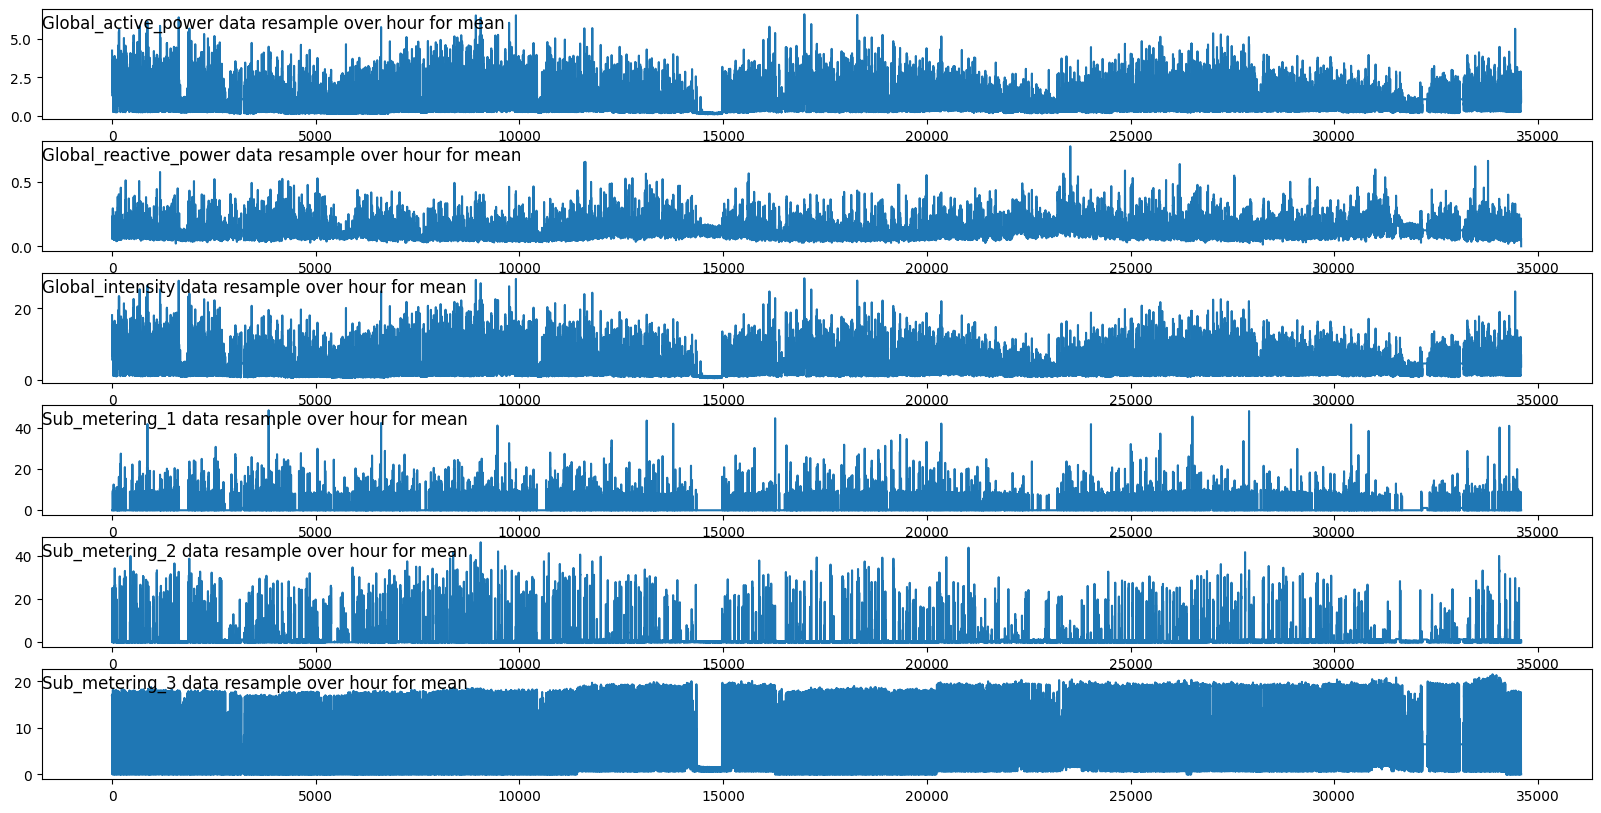

In [ ]:
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('H').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over hour for mean', y=0.75, loc='left')
    i += 1
plt.show()

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [ ]:
df = df[['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_2', 'Sub_metering_1','Sub_metering_3']]

df_resample = df.resample('h').mean()
df_resample.shape

(34589, 7)

In [ ]:
values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

# Data spliting into train and test data series. Only 4000 first data points are selected for traing purpose.
values = reframed.values
n_train_time = 4000 #train_size change anytime
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Network fitting
history = model.fit(train_x, train_y, epochs=50, batch_size=70, validation_data=(test_x, test_y), verbose=2, shuffle=False)


Epoch 1/50
58/58 - 3s - loss: 0.0284 - val_loss: 0.0108 - 3s/epoch - 59ms/step
Epoch 2/50
58/58 - 1s - loss: 0.0155 - val_loss: 0.0101 - 808ms/epoch - 14ms/step
Epoch 3/50
58/58 - 1s - loss: 0.0143 - val_loss: 0.0099 - 808ms/epoch - 14ms/step
Epoch 4/50
58/58 - 1s - loss: 0.0135 - val_loss: 0.0097 - 614ms/epoch - 11ms/step
Epoch 5/50
58/58 - 1s - loss: 0.0129 - val_loss: 0.0096 - 766ms/epoch - 13ms/step
Epoch 6/50
58/58 - 1s - loss: 0.0125 - val_loss: 0.0094 - 607ms/epoch - 10ms/step
Epoch 7/50
58/58 - 1s - loss: 0.0123 - val_loss: 0.0094 - 764ms/epoch - 13ms/step
Epoch 8/50
58/58 - 1s - loss: 0.0122 - val_loss: 0.0093 - 757ms/epoch - 13ms/step
Epoch 9/50
58/58 - 1s - loss: 0.0120 - val_loss: 0.0093 - 611ms/epoch - 11ms/step
Epoch 10/50
58/58 - 1s - loss: 0.0119 - val_loss: 0.0092 - 774ms/epoch - 13ms/step
Epoch 11/50
58/58 - 1s - loss: 0.0118 - val_loss: 0.0092 - 758ms/epoch - 13ms/step
Epoch 12/50
58/58 - 1s - loss: 0.0117 - val_loss: 0.0092 - 763ms/epoch - 13ms/step
Epoch 13/50
58/5

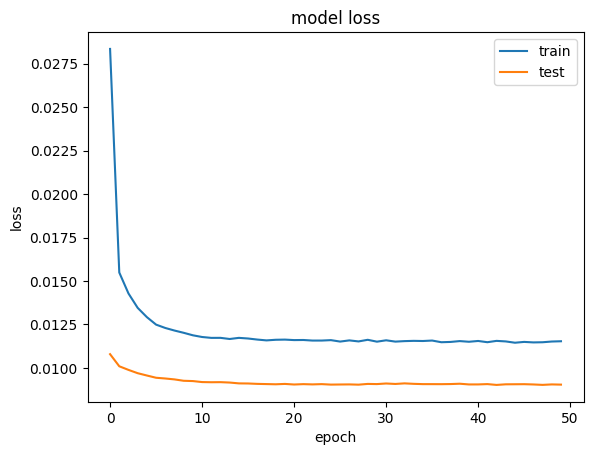

In [ ]:
# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [ ]:
size = df_resample.shape[1]

# Prediction test
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


956/956 [==============================] - 1s 1ms/step
Test RMSE: 0.612


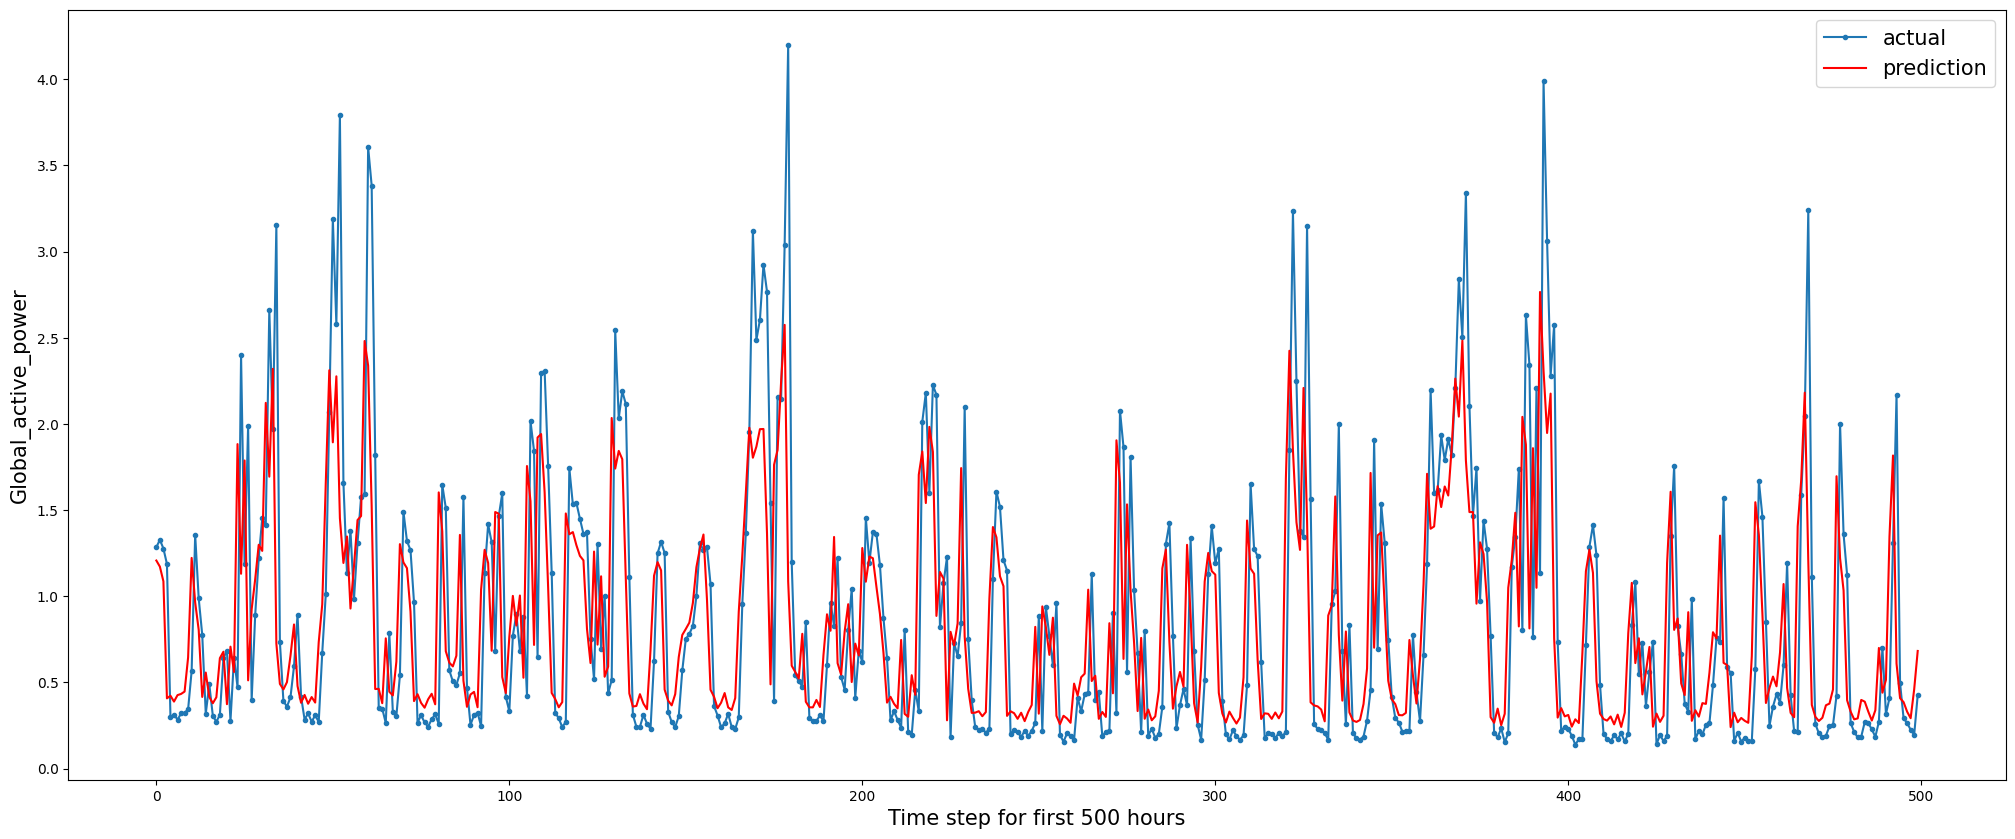

In [ ]:
aa=[x for x in range(500)]
plt.figure(figsize=(25,10))
plt.plot(aa, inv_y[:500], marker='.', label="actual")
plt.plot(aa, inv_yhat[:500], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for first 500 hours', size=15)
plt.legend(fontsize=15)
plt.show()